In [1]:
import numpy as np
import matplotlib.pylab as plt
#from scipy.misc import imresize, imread
import itertools
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline
# charger des images formes (5547, 50, 50, 3)
X = np.load('D:/test cancer rbreast/crop/zoo.npy')  

# charger des images  (5547,1); (0 = no cancer, 1 = cancer)
Y = np.load('D:/test cancer rbreast/crop/zoom.npy')   
perm_array = np.arange(len(X))
#arrange genere tous toute les val jusqua la longuer de x_images
np.random.shuffle(perm_array)
#il melange les images
X = X[perm_array]
Y = Y[perm_array]
#en split notre dataset 80 % 20 %
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
# en redduit la taille de l'echantillon au cas ou en avais trop d'images 
#pour pas que ca prend trop de temps pour le pc 
#mais ici c'est pas le cas donc en commente ce code
#X_train = X_train[0:30000] 
#Y_train = Y_train[0:30000]
#X_test = X_test[0:30000] 
#Y_test = Y_test[0:30000]
X_train = X_train / 256.0
X_test = X_test / 256.0
#methode qu'on a trouver sur internet et qu'on a utiliser 
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
#en applatit les donnees en gros en les transfrome en une matrice 1 seul dimmenssion nbr elem*(width*height*channel)
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    en va plot un learning curve grace au code de ce lien http://scikit-learn.org/stable/modules/learning_curve.html
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("exemples de test")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="score d'entrainement")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="score du cross validation")
    plt.legend(loc="best")
    return plt

def plotLotsOfLearningCurves(a,b):
    """ en va plot bcp de learning curve http://scikit-learn.org/stable/modules/learning_curve.html"""
    models = []
    models.append(('Support Vector Machine', SVC()))
    for name, model in models:
        plot_learning_curve(model, 'Learning Curve For %s Classifier'% (name), a,b, (0.5,1), 10)
#plotLotsOfLearningCurves(X_trainFlat, Y_train)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='matrice d econfusion',
                          cmap=plt.cm.Blues):
    """
    en affiche la matrice de confusion
    en peut normalizer les donnees en metant normalize a true
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Run SVC w/ Confusion Matrix
def runSVCconfusion(a,b,c,d):
    """methodes qui affiches les matrices de confusiondu model svc (comme exmeple) en normalizer et non normalizer"""
    model = SVC()
    model.fit(a, b)
    prediction = model.predict(c)
    kfold = model_selection.KFold(n_splits=10)
    accuracy = model_selection.cross_val_score(model, c,d, cv=kfold, scoring='accuracy')
    mean = accuracy.mean() 
    stdev = accuracy.std()
    print('\nSupport Vector Machine - Training set accuracy: %s (%s)' % (mean, stdev),"\n")
    cnf_matrix = confusion_matrix(d, prediction)
    np.set_printoptions(precision=2)
    class_names = ["diagnostic" "IDC(-)", "diagnostic" "IDC(+)"]
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, sans la normalization')
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title=' confusion matrix avec normalization')
    plt.show()
#runSVCconfusion(X_trainFlat, Y_train, X_testFlat, Y_test)
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)

Using TensorFlow backend.


In [ ]:
#simple model
def plotKerasLearningCurve():
    #en affiche juste la courbe de notre model
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('nombre d epoques')

def runKerasCNN(a,b,c,d):
    """
    en a utiliser ce lien
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    en a utilise run model qui marche bien sur MNIST sur notre dataset
    """
    batch_size = 128
    num_classes = 2
    epochs = 100 
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    model = Sequential()
    #test d'un premier model
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
     # checkpoint
    filepath="weights.traint_globalzoom_modelsimple_avec_crop2.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    history =model.fit(x_train, y_train,
              batch_size=batch_size,
              verbose=1,
              epochs=epochs,
              validation_data=(x_test, y_test),callbacks=callbacks_list)
    model.summary()
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN 1 - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
runKerasCNN(X_train, Y_train,  X_test, Y_test)
#plotKerasLearningCurve()

Train on 3968 samples, validate on 992 samples
Epoch 1/100


Train on 3968 samples, validate on 992 samples
Epoch 1/100
3968/3968 [==============================] - 6s 1ms/step - loss: 0.9262 - acc: 0.7349 - val_loss: 0.4372 - val_acc: 0.8125

Epoch 00001: val_acc improved from -inf to 0.81250, saving model to weights.traint_globalzoom_modelcomplex1_avec_crop.hdf5
Epoch 2/100
3968/3968 [==============================] - 3s 797us/step - loss: 0.3629 - acc: 0.8357 - val_loss: 1.1387 - val_acc: 0.5907

Epoch 00002: val_acc did not improve from 0.81250
Epoch 3/100
3968/3968 [==============================] - 3s 770us/step - loss: 0.3049 - acc: 0.8637 - val_loss: 0.9389 - val_acc: 0.7661

Epoch 00003: val_acc did not improve from 0.81250
Epoch 4/100
3968/3968 [==============================] - 3s 779us/step - loss: 0.2726 - acc: 0.8783 - val_loss: 1.4096 - val_acc: 0.4012

Epoch 00004: val_acc did not improve from 0.81250
Epoch 5/100
3968/3968 [==============================] - 3s 783us/step - loss: 0.2569 - acc: 0.8821 - val_loss: 6.2493 - val_acc: 


Epoch 00042: val_acc did not improve from 0.94556
Epoch 43/100
3968/3968 [==============================] - 3s 776us/step - loss: 0.0241 - acc: 0.9917 - val_loss: 1.6780 - val_acc: 0.7923

Epoch 00043: val_acc did not improve from 0.94556
Epoch 44/100
3968/3968 [==============================] - 3s 779us/step - loss: 0.0453 - acc: 0.9859 - val_loss: 3.7275 - val_acc: 0.6411

Epoch 00044: val_acc did not improve from 0.94556
Epoch 45/100
3968/3968 [==============================] - 3s 776us/step - loss: 0.0334 - acc: 0.9879 - val_loss: 0.3601 - val_acc: 0.9113

Epoch 00045: val_acc did not improve from 0.94556
Epoch 46/100
3968/3968 [==============================] - 3s 770us/step - loss: 0.0182 - acc: 0.9940 - val_loss: 0.6986 - val_acc: 0.8962

Epoch 00046: val_acc did not improve from 0.94556
Epoch 47/100
3968/3968 [==============================] - 3s 776us/step - loss: 0.0094 - acc: 0.9965 - val_loss: 0.4720 - val_acc: 0.9143

Epoch 00047: val_acc did not improve from 0.94556
Epoc


Epoch 00085: val_acc did not improve from 0.97984
Epoch 86/100
3968/3968 [==============================] - 3s 780us/step - loss: 0.0057 - acc: 0.9985 - val_loss: 0.3556 - val_acc: 0.9355

Epoch 00086: val_acc did not improve from 0.97984
Epoch 87/100
3968/3968 [==============================] - 3s 772us/step - loss: 0.0130 - acc: 0.9960 - val_loss: 2.7477 - val_acc: 0.7198

Epoch 00087: val_acc did not improve from 0.97984
Epoch 88/100
3968/3968 [==============================] - 3s 778us/step - loss: 0.0067 - acc: 0.9975 - val_loss: 0.8386 - val_acc: 0.8901

Epoch 00088: val_acc did not improve from 0.97984
Epoch 89/100
3968/3968 [==============================] - 3s 776us/step - loss: 0.0085 - acc: 0.9977 - val_loss: 0.6946 - val_acc: 0.8921

Epoch 00089: val_acc did not improve from 0.97984
Epoch 90/100
3968/3968 [==============================] - 3s 809us/step - loss: 0.0053 - acc: 0.9982 - val_loss: 0.7490 - val_acc: 0.8942

Epoch 00090: val_acc did not improve from 0.97984
Epoc

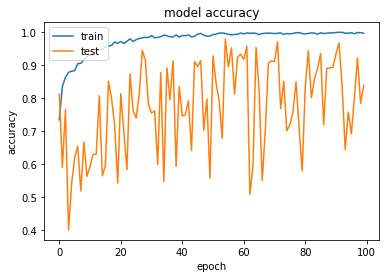

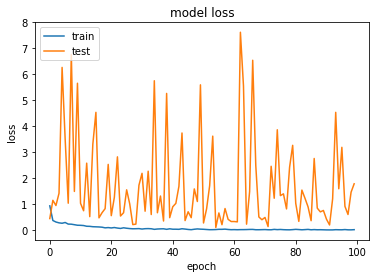

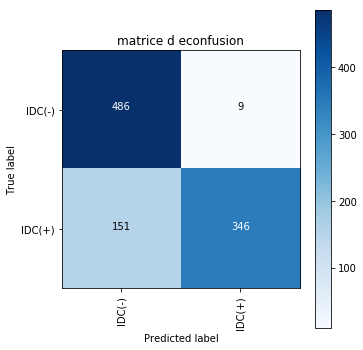

In [7]:
def runKerasCNN(a,b,c,d):
    """
    en a utiliser ce lien
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    en a utilise run model qui marche bien sur MNIST sur notre dataset
    """
    batch_size = 128
    num_classes = 2
    epochs = 100 
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    model = Sequential()
    #test d'un premier model
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu', input_shape = input_shape))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = "softmax"))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
     # checkpoint
    filepath="weights.traint_globalzoom_modelcomplex1_avec_crop.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    history =model.fit(x_train, y_train,
              batch_size=batch_size,
              verbose=1,
              epochs=epochs,
              validation_data=(x_test, y_test),callbacks=callbacks_list)
    model.summary()
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN 1 - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
runKerasCNN(X_train, Y_train,  X_test, Y_test)
#plotKerasLearningCurve()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 50, 50, 32)        896       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 25, 25, 32)        128       
_________________________________________________________________
dropout_8 (Dropout)          (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 25, 25, 64)        18496     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 25, 25, 64)        36928     
__________

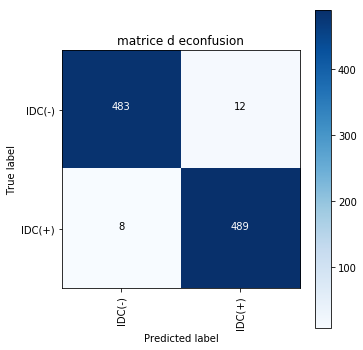

In [8]:
def runKerasCNN(a,b,c,d):
    """
    en a utiliser ce lien
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    en a utilise run model qui marche bien sur MNIST sur notre dataset
    """
    batch_size = 128
    num_classes = 2
    epochs = 5
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    model = Sequential()
    #test d'un premier model
    #test d'un premier model
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu', input_shape = input_shape))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = "softmax"))
    # load weights
    model.load_weights("weights.traint_globalzoom_modelcomplex1_avec_crop.hdf5")
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    model.summary()
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN 1 - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
     
runKerasCNN(X_train, Y_train,  X_test, Y_test)
#plotKerasLearningCurve()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 50, 50, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 25, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 64)        36928     
__________

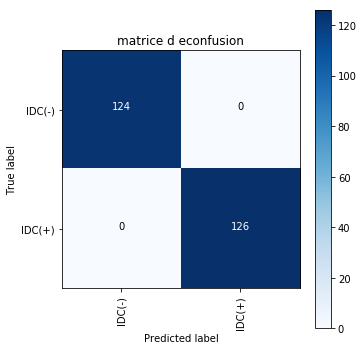

In [2]:
# charger des images formes (5547, 50, 50, 3)
X = np.load('D:/test cancer rbreast/crop/zoom_40m.npy')  

# charger des images  (5547,1); (0 = no cancer, 1 = cancer)
Y = np.load('D:/test cancer rbreast/crop/zoom_40m_label.npy')   
perm_array = np.arange(len(X))
#arrange genere tous toute les val jusqua la longuer de x_images
np.random.shuffle(perm_array)
#il melange les images
X = X[perm_array]
Y = Y[perm_array]
#en split notre dataset 80 % 20 %
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
# en redduit la taille de l'echantillon au cas ou en avais trop d'images 
#pour pas que ca prend trop de temps pour le pc 
#mais ici c'est pas le cas donc en commente ce code
#X_train = X_train[0:30000] 
#Y_train = Y_train[0:30000]
#X_test = X_test[0:30000] 
#Y_test = Y_test[0:30000]

# normalizer nos donnees 
#en pourrais utiliser d'autre methodes aussi mais celle la c'est bien 
X_train = X_train / 256.0
X_test = X_test / 256.0
#methode qu'on a trouver sur internet et qu'on a utiliser 
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
#en applatit les donnees en gros en les transfrome en une matrice 1 seul dimmenssion nbr elem*(width*height*channel)
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
class MetricsCheckpoint(Callback):
    """apres chaque epoch en sauvegarde metrics"""
    def __init__(self, savepath):
        #constructeur de la class
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    #en affiche juste la courbe de notre model
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('nombre d epoques')
def runKerasCNN(a,b,c,d):
    """
    en a utiliser ce lien
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    en a utilise run model qui marche bien sur MNIST sur notre dataset
    """
    batch_size = 128
    num_classes = 2
    epochs = 5
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    model = Sequential()
    #test d'un premier model
    #test d'un premier model
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu', input_shape = input_shape))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = "softmax"))
    # load weights
    model.load_weights("weights.traint_globalzoom_modelcomplex1_avec_crop.hdf5")
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    model.summary()
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN 1 - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
     
runKerasCNN(X_train, Y_train,  X_test, Y_test)
#plotKerasLearningCurve()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 50, 50, 32)        896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 25, 25, 32)        128       
_________________________________________________________________
dropout_6 (Dropout)          (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 25, 25, 64)        36928     
__________

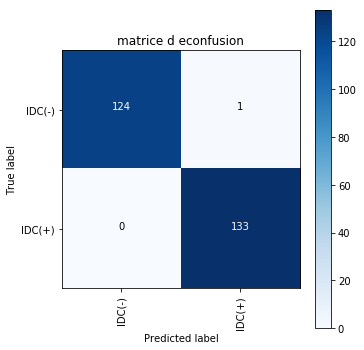

In [3]:
# charger des images formes (5547, 50, 50, 3)
X = np.load('D:/test cancer rbreast/crop/zoom_100m.npy')  

# charger des images  (5547,1); (0 = no cancer, 1 = cancer)
Y = np.load('D:/test cancer rbreast/crop/zoom_100m_label.npy')   
perm_array = np.arange(len(X))
#arrange genere tous toute les val jusqua la longuer de x_images
np.random.shuffle(perm_array)
#il melange les images
X = X[perm_array]
Y = Y[perm_array]
#en split notre dataset 80 % 20 %
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
# en redduit la taille de l'echantillon au cas ou en avais trop d'images 
#pour pas que ca prend trop de temps pour le pc 
#mais ici c'est pas le cas donc en commente ce code
#X_train = X_train[0:30000] 
#Y_train = Y_train[0:30000]
#X_test = X_test[0:30000] 
#Y_test = Y_test[0:30000]

# normalizer nos donnees 
#en pourrais utiliser d'autre methodes aussi mais celle la c'est bien 
X_train = X_train / 256.0
X_test = X_test / 256.0
#methode qu'on a trouver sur internet et qu'on a utiliser 
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
#en applatit les donnees en gros en les transfrome en une matrice 1 seul dimmenssion nbr elem*(width*height*channel)
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
class MetricsCheckpoint(Callback):
    """apres chaque epoch en sauvegarde metrics"""
    def __init__(self, savepath):
        #constructeur de la class
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    #en affiche juste la courbe de notre model
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('nombre d epoques')
def runKerasCNN(a,b,c,d):
    """
    en a utiliser ce lien
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    en a utilise run model qui marche bien sur MNIST sur notre dataset
    """
    batch_size = 128
    num_classes = 2
    epochs = 5
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    model = Sequential()
    #test d'un premier model
    #test d'un premier model
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu', input_shape = input_shape))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = "softmax"))
    # load weights
    model.load_weights("weights.traint_globalzoom_modelcomplex1_avec_crop.hdf5")
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    model.summary()
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN 1 - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
     
runKerasCNN(X_train, Y_train,  X_test, Y_test)
#plotKerasLearningCurve()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 50, 50, 32)        896       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 25, 25, 32)        128       
_________________________________________________________________
dropout_11 (Dropout)         (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 25, 25, 64)        18496     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 25, 25, 64)        36928     
__________

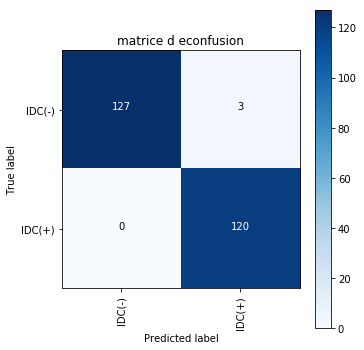

In [4]:
# charger des images formes (5547, 50, 50, 3)
X = np.load('D:/test cancer rbreast/crop/zoom_200m.npy')  

# charger des images  (5547,1); (0 = no cancer, 1 = cancer)
Y = np.load('D:/test cancer rbreast/crop/zoom_200m_label.npy')   
perm_array = np.arange(len(X))
#arrange genere tous toute les val jusqua la longuer de x_images
np.random.shuffle(perm_array)
#il melange les images
X = X[perm_array]
Y = Y[perm_array]
#en split notre dataset 80 % 20 %
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
# en redduit la taille de l'echantillon au cas ou en avais trop d'images 
#pour pas que ca prend trop de temps pour le pc 
#mais ici c'est pas le cas donc en commente ce code
#X_train = X_train[0:30000] 
#Y_train = Y_train[0:30000]
#X_test = X_test[0:30000] 
#Y_test = Y_test[0:30000]

# normalizer nos donnees 
#en pourrais utiliser d'autre methodes aussi mais celle la c'est bien 
X_train = X_train / 256.0
X_test = X_test / 256.0
#methode qu'on a trouver sur internet et qu'on a utiliser 
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
#en applatit les donnees en gros en les transfrome en une matrice 1 seul dimmenssion nbr elem*(width*height*channel)
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
class MetricsCheckpoint(Callback):
    """apres chaque epoch en sauvegarde metrics"""
    def __init__(self, savepath):
        #constructeur de la class
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    #en affiche juste la courbe de notre model
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('nombre d epoques')
def runKerasCNN(a,b,c,d):
    """
    en a utiliser ce lien
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    en a utilise run model qui marche bien sur MNIST sur notre dataset
    """
    batch_size = 128
    num_classes = 2
    epochs = 5
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    model = Sequential()
    #test d'un premier model
    #test d'un premier model
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu', input_shape = input_shape))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = "softmax"))
    # load weights
    model.load_weights("weights.traint_globalzoom_modelcomplex1_avec_crop.hdf5")
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    model.summary()
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN 1 - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
     
runKerasCNN(X_train, Y_train,  X_test, Y_test)
#plotKerasLearningCurve()

In [ ]:
# charger des images formes (5547, 50, 50, 3)
X = np.load('D:/test cancer rbreast/crop/zoom_40m.npy')  

# charger des images  (5547,1); (0 = no cancer, 1 = cancer)
Y = np.load('D:/test cancer rbreast/crop/zoom_40m_label.npy')   
perm_array = np.arange(len(X))
#arrange genere tous toute les val jusqua la longuer de x_images
np.random.shuffle(perm_array)
#il melange les images
X = X[perm_array]
Y = Y[perm_array]
#en split notre dataset 80 % 20 %
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
# en redduit la taille de l'echantillon au cas ou en avais trop d'images 
#pour pas que ca prend trop de temps pour le pc 
#mais ici c'est pas le cas donc en commente ce code
#X_train = X_train[0:30000] 
#Y_train = Y_train[0:30000]
#X_test = X_test[0:30000] 
#Y_test = Y_test[0:30000]

# normalizer nos donnees 
#en pourrais utiliser d'autre methodes aussi mais celle la c'est bien 
X_train = X_train / 256.0
X_test = X_test / 256.0
#methode qu'on a trouver sur internet et qu'on a utiliser 
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
#en applatit les donnees en gros en les transfrome en une matrice 1 seul dimmenssion nbr elem*(width*height*channel)
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
class MetricsCheckpoint(Callback):
    """apres chaque epoch en sauvegarde metrics"""
    def __init__(self, savepath):
        #constructeur de la class
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    #en affiche juste la courbe de notre model
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('nombre d epoques')
def runKerasCNN(a,b,c,d):
    """
    en a utiliser ce lien
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    en a utilise run model qui marche bien sur MNIST sur notre dataset
    """
    batch_size = 128
    num_classes = 2
    epochs = 5
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    model = Sequential()
    #test d'un premier model
    #test d'un premier model
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu', input_shape = input_shape))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = "softmax"))
    # load weights
    model.load_weights("weights.traint_globalzoom_modelcomplex1_avec_crop.hdf5")
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    model.summary()
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN 1 - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
     
runKerasCNN(X_train, Y_train,  X_test, Y_test)
#plotKerasLearningCurve()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 23, 23, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 33856)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               4333696   
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
__________

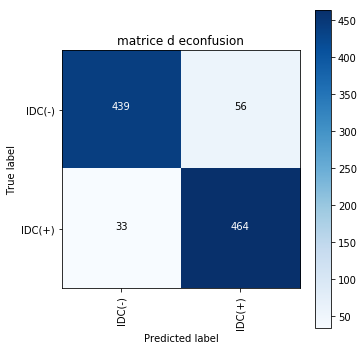

In [9]:
def runKerasCNN(a,b,c,d):
    """
    en a utiliser ce lien
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    en a utilise run model qui marche bien sur MNIST sur notre dataset
    """
    batch_size = 128
    num_classes = 2
    epochs = 5
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    model = Sequential()
    #test d'un premier model
    #test d'un premier model
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    # load weights
    model.load_weights("weights.traint_globalzoom_modelsimple_avec_crop.hdf5")
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    model.summary()
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN 1 - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
     
runKerasCNN(X_train, Y_train,  X_test, Y_test)
#plotKerasLearningCurve()

In [10]:
import numpy as np
import matplotlib.pylab as plt
#from scipy.misc import imresize, imread
import itertools
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline
# charger des images formes (5547, 50, 50, 3)
X = np.load('D:/test cancer rbreast/linear/zoo.npy')  

# charger des images  (5547,1); (0 = no cancer, 1 = cancer)
Y = np.load('D:/test cancer rbreast/linear/zoom.npy')   
perm_array = np.arange(len(X))
#arrange genere tous toute les val jusqua la longuer de x_images
np.random.shuffle(perm_array)
#il melange les images
X = X[perm_array]
Y = Y[perm_array]
#en split notre dataset 80 % 20 %
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
# en redduit la taille de l'echantillon au cas ou en avais trop d'images 
#pour pas que ca prend trop de temps pour le pc 
#mais ici c'est pas le cas donc en commente ce code
#X_train = X_train[0:30000] 
#Y_train = Y_train[0:30000]
#X_test = X_test[0:30000] 
#Y_test = Y_test[0:30000]
X_train = X_train / 256.0
X_test = X_test / 256.0
#methode qu'on a trouver sur internet et qu'on a utiliser 
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
#en applatit les donnees en gros en les transfrome en une matrice 1 seul dimmenssion nbr elem*(width*height*channel)
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    en va plot un learning curve grace au code de ce lien http://scikit-learn.org/stable/modules/learning_curve.html
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("exemples de test")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="score d'entrainement")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="score du cross validation")
    plt.legend(loc="best")
    return plt

def plotLotsOfLearningCurves(a,b):
    """ en va plot bcp de learning curve http://scikit-learn.org/stable/modules/learning_curve.html"""
    models = []
    models.append(('Support Vector Machine', SVC()))
    for name, model in models:
        plot_learning_curve(model, 'Learning Curve For %s Classifier'% (name), a,b, (0.5,1), 10)
#plotLotsOfLearningCurves(X_trainFlat, Y_train)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='matrice d econfusion',
                          cmap=plt.cm.Blues):
    """
    en affiche la matrice de confusion
    en peut normalizer les donnees en metant normalize a true
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Run SVC w/ Confusion Matrix
def runSVCconfusion(a,b,c,d):
    """methodes qui affiches les matrices de confusiondu model svc (comme exmeple) en normalizer et non normalizer"""
    model = SVC()
    model.fit(a, b)
    prediction = model.predict(c)
    kfold = model_selection.KFold(n_splits=10)
    accuracy = model_selection.cross_val_score(model, c,d, cv=kfold, scoring='accuracy')
    mean = accuracy.mean() 
    stdev = accuracy.std()
    print('\nSupport Vector Machine - Training set accuracy: %s (%s)' % (mean, stdev),"\n")
    cnf_matrix = confusion_matrix(d, prediction)
    np.set_printoptions(precision=2)
    class_names = ["diagnostic" "IDC(-)", "diagnostic" "IDC(+)"]
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, sans la normalization')
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title=' confusion matrix avec normalization')
    plt.show()
#runSVCconfusion(X_trainFlat, Y_train, X_testFlat, Y_test)
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)

Train on 3968 samples, validate on 992 samples
Epoch 1/100
3968/3968 [==============================] - 5s 1ms/step - loss: 0.8550 - acc: 0.5756 - val_loss: 0.5936 - val_acc: 0.8125

Epoch 00001: val_acc improved from -inf to 0.81250, saving model to weights.traint_globalzoom_modelsimple_linear.hdf5
Epoch 2/100
3968/3968 [==============================] - 2s 570us/step - loss: 0.6533 - acc: 0.6247 - val_loss: 0.6576 - val_acc: 0.4889

Epoch 00002: val_acc did not improve from 0.81250
Epoch 3/100
3968/3968 [==============================] - 2s 614us/step - loss: 0.6381 - acc: 0.6694 - val_loss: 0.5931 - val_acc: 0.7036

Epoch 00003: val_acc did not improve from 0.81250
Epoch 4/100
3968/3968 [==============================] - 2s 608us/step - loss: 0.6169 - acc: 0.6835 - val_loss: 0.6240 - val_acc: 0.6240

Epoch 00004: val_acc did not improve from 0.81250
Epoch 5/100
3968/3968 [==============================] - 2s 585us/step - loss: 0.6057 - acc: 0.6860 - val_loss: 0.4766 - val_acc: 0.795

3968/3968 [==============================] - 3s 640us/step - loss: 0.3472 - acc: 0.8380 - val_loss: 0.2800 - val_acc: 0.8780

Epoch 00042: val_acc did not improve from 0.88508
Epoch 43/100
3968/3968 [==============================] - 2s 593us/step - loss: 0.3246 - acc: 0.8558 - val_loss: 0.2577 - val_acc: 0.8881

Epoch 00043: val_acc improved from 0.88508 to 0.88810, saving model to weights.traint_globalzoom_modelsimple_linear.hdf5
Epoch 44/100
3968/3968 [==============================] - 2s 588us/step - loss: 0.3056 - acc: 0.8594 - val_loss: 0.2477 - val_acc: 0.8881

Epoch 00044: val_acc did not improve from 0.88810
Epoch 45/100
3968/3968 [==============================] - 2s 622us/step - loss: 0.3111 - acc: 0.8551 - val_loss: 0.6624 - val_acc: 0.6079

Epoch 00045: val_acc did not improve from 0.88810
Epoch 46/100
3968/3968 [==============================] - 3s 658us/step - loss: 0.2933 - acc: 0.8674 - val_loss: 0.2437 - val_acc: 0.8881

Epoch 00046: val_acc did not improve from 0.888

3968/3968 [==============================] - 2s 625us/step - loss: 0.0396 - acc: 0.9879 - val_loss: 2.4372 - val_acc: 0.5181

Epoch 00082: val_acc did not improve from 0.90927
Epoch 83/100
3968/3968 [==============================] - 2s 580us/step - loss: 0.1395 - acc: 0.9622 - val_loss: 0.2828 - val_acc: 0.9073

Epoch 00083: val_acc did not improve from 0.90927
Epoch 84/100
3968/3968 [==============================] - 2s 567us/step - loss: 0.0204 - acc: 0.9962 - val_loss: 0.3535 - val_acc: 0.9052

Epoch 00084: val_acc did not improve from 0.90927
Epoch 85/100
3968/3968 [==============================] - 2s 572us/step - loss: 0.1122 - acc: 0.9667 - val_loss: 0.2453 - val_acc: 0.9083

Epoch 00085: val_acc did not improve from 0.90927
Epoch 86/100
3968/3968 [==============================] - 2s 578us/step - loss: 0.0249 - acc: 0.9957 - val_loss: 0.3322 - val_acc: 0.8982

Epoch 00086: val_acc did not improve from 0.90927
Epoch 87/100
3968/3968 [==============================] - 2s 590us/s

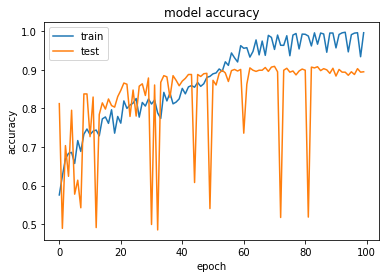

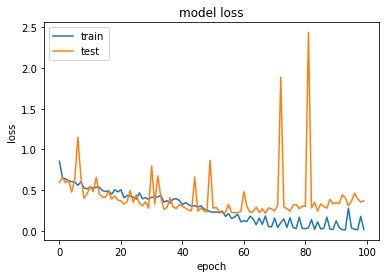

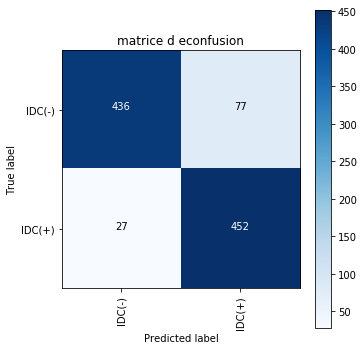

In [23]:
#simple model
def plotKerasLearningCurve():
    #en affiche juste la courbe de notre model
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('nombre d epoques')

def runKerasCNN(a,b,c,d):
    """
    en a utiliser ce lien
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    en a utilise run model qui marche bien sur MNIST sur notre dataset
    """
    batch_size = 128
    num_classes = 2
    epochs = 100 
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    model = Sequential()
    #test d'un premier model
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
     # checkpoint
    filepath="weights.traint_globalzoom_modelsimple_linear.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    history =model.fit(x_train, y_train,
              batch_size=batch_size,
              verbose=1,
              epochs=epochs,
              validation_data=(x_test, y_test),callbacks=callbacks_list)
    model.summary()
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN 1 - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
runKerasCNN(X_train, Y_train,  X_test, Y_test)
#plotKerasLearningCurve()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 23, 23, 64)        0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 33856)             0         
_________________________________________________________________
dense_37 (Dense)             (None, 128)               4333696   
_________________________________________________________________
dropout_50 (Dropout)         (None, 128)               0         
__________

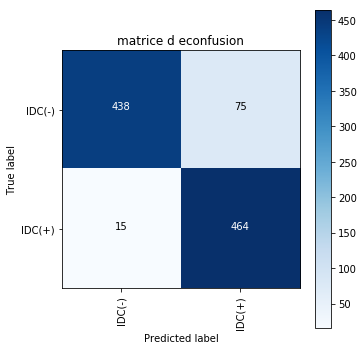

In [24]:
def runKerasCNN(a,b,c,d):
    """
    en a utiliser ce lien
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    en a utilise run model qui marche bien sur MNIST sur notre dataset
    """
    batch_size = 128
    num_classes = 2
    epochs = 5
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    model = Sequential()
    #test d'un premier model
    #test d'un premier model
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    # load weights
    model.load_weights("weights.traint_globalzoom_modelsimple_linear.hdf5")
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    model.summary()
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN 1 - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
     
runKerasCNN(X_train, Y_train,  X_test, Y_test)


Train on 3968 samples, validate on 992 samples
Epoch 1/100
3968/3968 [==============================] - 5s 1ms/step - loss: 0.9337 - acc: 0.7382 - val_loss: 0.9777 - val_acc: 0.8054

Epoch 00001: val_acc improved from -inf to 0.80544, saving model to weights.traint_globalzoom_modelcomplex1_linear.hdf5
Epoch 2/100
3968/3968 [==============================] - 3s 779us/step - loss: 0.3644 - acc: 0.8309 - val_loss: 0.6637 - val_acc: 0.5413

Epoch 00002: val_acc did not improve from 0.80544
Epoch 3/100
3968/3968 [==============================] - 3s 793us/step - loss: 0.2998 - acc: 0.8594 - val_loss: 0.6471 - val_acc: 0.6472

Epoch 00003: val_acc did not improve from 0.80544
Epoch 4/100
3968/3968 [==============================] - 3s 780us/step - loss: 0.2734 - acc: 0.8750 - val_loss: 1.5658 - val_acc: 0.7127

Epoch 00004: val_acc did not improve from 0.80544
Epoch 5/100
3968/3968 [==============================] - 3s 786us/step - loss: 0.2662 - acc: 0.8823 - val_loss: 1.6121 - val_acc: 0.5

3968/3968 [==============================] - 3s 780us/step - loss: 0.0204 - acc: 0.9927 - val_loss: 2.5904 - val_acc: 0.6986

Epoch 00042: val_acc did not improve from 0.94456
Epoch 43/100
3968/3968 [==============================] - 3s 789us/step - loss: 0.0152 - acc: 0.9947 - val_loss: 1.4726 - val_acc: 0.7510

Epoch 00043: val_acc did not improve from 0.94456
Epoch 44/100
3968/3968 [==============================] - 3s 783us/step - loss: 0.0430 - acc: 0.9864 - val_loss: 4.2144 - val_acc: 0.6290

Epoch 00044: val_acc did not improve from 0.94456
Epoch 45/100
3968/3968 [==============================] - 3s 783us/step - loss: 0.0264 - acc: 0.9904 - val_loss: 4.4278 - val_acc: 0.6472

Epoch 00045: val_acc did not improve from 0.94456
Epoch 46/100
3968/3968 [==============================] - 3s 779us/step - loss: 0.0212 - acc: 0.9924 - val_loss: 0.9072 - val_acc: 0.8246

Epoch 00046: val_acc did not improve from 0.94456
Epoch 47/100
3968/3968 [==============================] - 3s 783us/s

3968/3968 [==============================] - 3s 787us/step - loss: 0.0069 - acc: 0.9982 - val_loss: 3.3191 - val_acc: 0.7157

Epoch 00085: val_acc did not improve from 0.95565
Epoch 86/100
3968/3968 [==============================] - 3s 787us/step - loss: 0.0219 - acc: 0.9934 - val_loss: 3.5716 - val_acc: 0.6966

Epoch 00086: val_acc did not improve from 0.95565
Epoch 87/100
3968/3968 [==============================] - 3s 783us/step - loss: 0.0141 - acc: 0.9962 - val_loss: 1.4832 - val_acc: 0.8054

Epoch 00087: val_acc did not improve from 0.95565
Epoch 88/100
3968/3968 [==============================] - 3s 782us/step - loss: 0.0111 - acc: 0.9957 - val_loss: 0.9155 - val_acc: 0.8629

Epoch 00088: val_acc did not improve from 0.95565
Epoch 89/100
3968/3968 [==============================] - 3s 809us/step - loss: 0.0097 - acc: 0.9967 - val_loss: 0.3058 - val_acc: 0.9466

Epoch 00089: val_acc did not improve from 0.95565
Epoch 90/100
3968/3968 [==============================] - 3s 793us/s

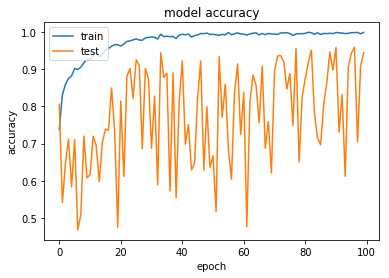

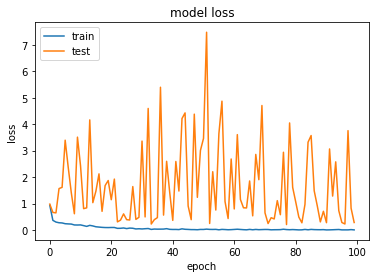

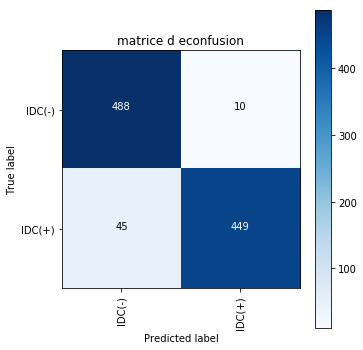

In [14]:
def runKerasCNN(a,b,c,d):
    """
    en a utiliser ce lien
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    en a utilise run model qui marche bien sur MNIST sur notre dataset
    """
    batch_size = 128
    num_classes = 2
    epochs = 100 
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    model = Sequential()
    #test d'un premier model
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu', input_shape = input_shape))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = "softmax"))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
     # checkpoint
    filepath="weights.traint_globalzoom_modelcomplex1_linear.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    history =model.fit(x_train, y_train,
              batch_size=batch_size,
              verbose=1,
              epochs=epochs,
              validation_data=(x_test, y_test),callbacks=callbacks_list)
    model.summary()
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN 1 - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
runKerasCNN(X_train, Y_train,  X_test, Y_test)
#plotKerasLearningCurve()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 50, 50, 32)        896       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 25, 25, 32)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 25, 25, 32)        128       
_________________________________________________________________
dropout_24 (Dropout)         (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 25, 25, 64)        18496     
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 25, 25, 64)        36928     
__________

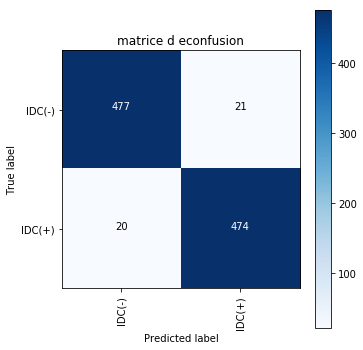

In [15]:
def runKerasCNN(a,b,c,d):
    """
    en a utiliser ce lien
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    en a utilise run model qui marche bien sur MNIST sur notre dataset
    """
    batch_size = 128
    num_classes = 2
    epochs = 5
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    model = Sequential()
    #test d'un premier model
    #test d'un premier model
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu', input_shape = input_shape))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = "softmax"))
    # load weights
    model.load_weights("weights.traint_globalzoom_modelcomplex1_linear.hdf5")
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    model.summary()
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN 1 - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
     
runKerasCNN(X_train, Y_train,  X_test, Y_test)
#plotKerasLearningCurve()

In [16]:
import numpy as np
import matplotlib.pylab as plt
#from scipy.misc import imresize, imread
import itertools
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline
# charger des images formes (5547, 50, 50, 3)
X = np.load('D:/test cancer rbreast/z/zoo.npy')  

# charger des images  (5547,1); (0 = no cancer, 1 = cancer)
Y = np.load('D:/test cancer rbreast/z/zoom.npy')   
perm_array = np.arange(len(X))
#arrange genere tous toute les val jusqua la longuer de x_images
np.random.shuffle(perm_array)
#il melange les images
X = X[perm_array]
Y = Y[perm_array]
#en split notre dataset 80 % 20 %
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
# en redduit la taille de l'echantillon au cas ou en avais trop d'images 
#pour pas que ca prend trop de temps pour le pc 
#mais ici c'est pas le cas donc en commente ce code
#X_train = X_train[0:30000] 
#Y_train = Y_train[0:30000]
#X_test = X_test[0:30000] 
#Y_test = Y_test[0:30000]
X_train = X_train / 256.0
X_test = X_test / 256.0
#methode qu'on a trouver sur internet et qu'on a utiliser 
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
#en applatit les donnees en gros en les transfrome en une matrice 1 seul dimmenssion nbr elem*(width*height*channel)
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    en va plot un learning curve grace au code de ce lien http://scikit-learn.org/stable/modules/learning_curve.html
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("exemples de test")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="score d'entrainement")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="score du cross validation")
    plt.legend(loc="best")
    return plt

def plotLotsOfLearningCurves(a,b):
    """ en va plot bcp de learning curve http://scikit-learn.org/stable/modules/learning_curve.html"""
    models = []
    models.append(('Support Vector Machine', SVC()))
    for name, model in models:
        plot_learning_curve(model, 'Learning Curve For %s Classifier'% (name), a,b, (0.5,1), 10)
#plotLotsOfLearningCurves(X_trainFlat, Y_train)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='matrice d econfusion',
                          cmap=plt.cm.Blues):
    """
    en affiche la matrice de confusion
    en peut normalizer les donnees en metant normalize a true
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Run SVC w/ Confusion Matrix
def runSVCconfusion(a,b,c,d):
    """methodes qui affiches les matrices de confusiondu model svc (comme exmeple) en normalizer et non normalizer"""
    model = SVC()
    model.fit(a, b)
    prediction = model.predict(c)
    kfold = model_selection.KFold(n_splits=10)
    accuracy = model_selection.cross_val_score(model, c,d, cv=kfold, scoring='accuracy')
    mean = accuracy.mean() 
    stdev = accuracy.std()
    print('\nSupport Vector Machine - Training set accuracy: %s (%s)' % (mean, stdev),"\n")
    cnf_matrix = confusion_matrix(d, prediction)
    np.set_printoptions(precision=2)
    class_names = ["diagnostic" "IDC(-)", "diagnostic" "IDC(+)"]
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, sans la normalization')
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title=' confusion matrix avec normalization')
    plt.show()
#runSVCconfusion(X_trainFlat, Y_train, X_testFlat, Y_test)
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)

Train on 3968 samples, validate on 992 samples
Epoch 1/100
3968/3968 [==============================] - 4s 941us/step - loss: 0.7276 - acc: 0.5547 - val_loss: 0.6645 - val_acc: 0.5101

Epoch 00001: val_acc improved from -inf to 0.51008, saving model to weights.traint_globalzoom_modelsimple.hdf5
Epoch 2/100
3968/3968 [==============================] - 2s 560us/step - loss: 0.7146 - acc: 0.6167 - val_loss: 0.6447 - val_acc: 0.4849

Epoch 00002: val_acc did not improve from 0.51008
Epoch 3/100
3968/3968 [==============================] - 2s 564us/step - loss: 0.6522 - acc: 0.6391 - val_loss: 0.5810 - val_acc: 0.8145

Epoch 00003: val_acc improved from 0.51008 to 0.81452, saving model to weights.traint_globalzoom_modelsimple.hdf5
Epoch 4/100
3968/3968 [==============================] - 2s 556us/step - loss: 0.6222 - acc: 0.6769 - val_loss: 0.5952 - val_acc: 0.7510

Epoch 00004: val_acc did not improve from 0.81452
Epoch 5/100
3968/3968 [==============================] - 2s 566us/step - los


Epoch 00081: val_acc did not improve from 0.90524
Epoch 82/100
3968/3968 [==============================] - 3s 645us/step - loss: 0.0276 - acc: 0.9937 - val_loss: 0.2927 - val_acc: 0.9012

Epoch 00082: val_acc did not improve from 0.90524
Epoch 83/100
3968/3968 [==============================] - 2s 604us/step - loss: 0.1419 - acc: 0.9486 - val_loss: 0.2766 - val_acc: 0.9022

Epoch 00083: val_acc did not improve from 0.90524
Epoch 84/100
3968/3968 [==============================] - 2s 596us/step - loss: 0.0282 - acc: 0.9955 - val_loss: 0.2816 - val_acc: 0.9002

Epoch 00084: val_acc did not improve from 0.90524
Epoch 85/100
3968/3968 [==============================] - 2s 597us/step - loss: 0.0745 - acc: 0.9738 - val_loss: 0.2921 - val_acc: 0.9012

Epoch 00085: val_acc did not improve from 0.90524
Epoch 86/100
3968/3968 [==============================] - 2s 577us/step - loss: 0.0263 - acc: 0.9932 - val_loss: 0.4015 - val_acc: 0.8982

Epoch 00086: val_acc did not improve from 0.90524
Epoc

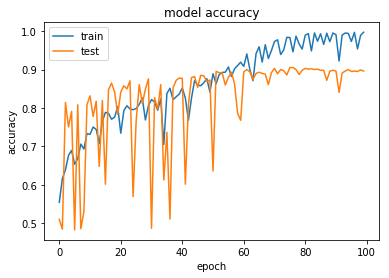

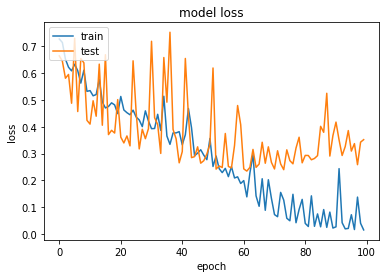

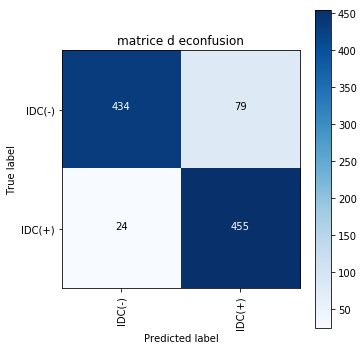

In [17]:
#simple model
def plotKerasLearningCurve():
    #en affiche juste la courbe de notre model
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('nombre d epoques')

def runKerasCNN(a,b,c,d):
    """
    en a utiliser ce lien
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    en a utilise run model qui marche bien sur MNIST sur notre dataset
    """
    batch_size = 128
    num_classes = 2
    epochs = 100 
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    model = Sequential()
    #test d'un premier model
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
     # checkpoint
    filepath="weights.traint_globalzoom_modelsimple.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    history =model.fit(x_train, y_train,
              batch_size=batch_size,
              verbose=1,
              epochs=epochs,
              validation_data=(x_test, y_test),callbacks=callbacks_list)
    model.summary()
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN 1 - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
runKerasCNN(X_train, Y_train,  X_test, Y_test)
#plotKerasLearningCurve()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 23, 23, 64)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 33856)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 128)               4333696   
_________________________________________________________________
dropout_32 (Dropout)         (None, 128)               0         
__________

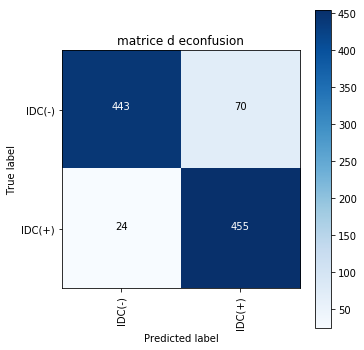

In [18]:
def runKerasCNN(a,b,c,d):
    """
    en a utiliser ce lien
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    en a utilise run model qui marche bien sur MNIST sur notre dataset
    """
    batch_size = 128
    num_classes = 2
    epochs = 5
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    model = Sequential()
    #test d'un premier model
    #test d'un premier model
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    # load weights
    model.load_weights("weights.traint_globalzoom_modelsimple.hdf5")
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    model.summary()
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN 1 - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
     
runKerasCNN(X_train, Y_train,  X_test, Y_test)


Train on 3968 samples, validate on 992 samples
Epoch 1/100
3968/3968 [==============================] - 5s 1ms/step - loss: 0.8630 - acc: 0.7545 - val_loss: 1.1169 - val_acc: 0.6200

Epoch 00001: val_acc improved from -inf to 0.61996, saving model to weights.traint_globalzoom_modelcomplex1.hdf5
Epoch 2/100
3968/3968 [==============================] - 3s 779us/step - loss: 0.3769 - acc: 0.8357 - val_loss: 3.4422 - val_acc: 0.4980

Epoch 00002: val_acc did not improve from 0.61996
Epoch 3/100
3968/3968 [==============================] - 3s 780us/step - loss: 0.3205 - acc: 0.8566 - val_loss: 0.6244 - val_acc: 0.8004

Epoch 00003: val_acc improved from 0.61996 to 0.80040, saving model to weights.traint_globalzoom_modelcomplex1.hdf5
Epoch 4/100
3968/3968 [==============================] - 3s 783us/step - loss: 0.2993 - acc: 0.8705 - val_loss: 1.5473 - val_acc: 0.7369

Epoch 00004: val_acc did not improve from 0.80040
Epoch 5/100
3968/3968 [==============================] - 3s 779us/step - l

3968/3968 [==============================] - 3s 816us/step - loss: 0.0124 - acc: 0.9972 - val_loss: 0.4496 - val_acc: 0.8982

Epoch 00085: val_acc did not improve from 0.96270
Epoch 86/100
3968/3968 [==============================] - 3s 809us/step - loss: 0.0018 - acc: 0.9997 - val_loss: 1.5268 - val_acc: 0.8276

Epoch 00086: val_acc did not improve from 0.96270
Epoch 87/100
3968/3968 [==============================] - 3s 800us/step - loss: 0.0092 - acc: 0.9972 - val_loss: 1.5528 - val_acc: 0.7550

Epoch 00087: val_acc did not improve from 0.96270
Epoch 88/100
3968/3968 [==============================] - 3s 803us/step - loss: 0.0038 - acc: 0.9985 - val_loss: 0.2680 - val_acc: 0.9405

Epoch 00088: val_acc did not improve from 0.96270
Epoch 89/100
3968/3968 [==============================] - 3s 801us/step - loss: 0.0025 - acc: 0.9992 - val_loss: 0.5051 - val_acc: 0.9143

Epoch 00089: val_acc did not improve from 0.96270
Epoch 90/100
3968/3968 [==============================] - 3s 802us/s

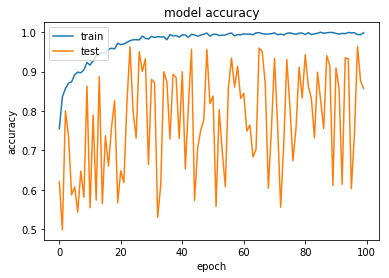

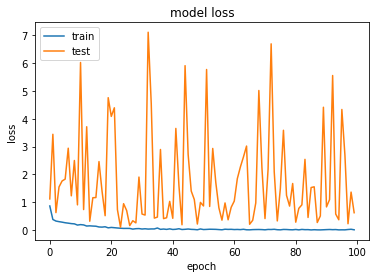

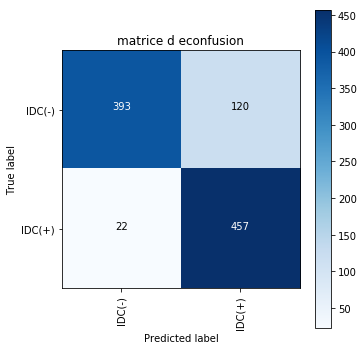

In [21]:
def runKerasCNN(a,b,c,d):
    """
    en a utiliser ce lien
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    en a utilise run model qui marche bien sur MNIST sur notre dataset
    """
    batch_size = 128
    num_classes = 2
    epochs = 100 
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    model = Sequential()
    #test d'un premier model
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu', input_shape = input_shape))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = "softmax"))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
     # checkpoint
    filepath="weights.traint_globalzoom_modelcomplex1.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    history =model.fit(x_train, y_train,
              batch_size=batch_size,
              verbose=1,
              epochs=epochs,
              validation_data=(x_test, y_test),callbacks=callbacks_list)
    model.summary()
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN 1 - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
runKerasCNN(X_train, Y_train,  X_test, Y_test)
#plotKerasLearningCurve()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 50, 50, 32)        896       
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 25, 25, 32)        0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 25, 25, 32)        128       
_________________________________________________________________
dropout_42 (Dropout)         (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 25, 25, 64)        18496     
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 25, 25, 64)        36928     
__________

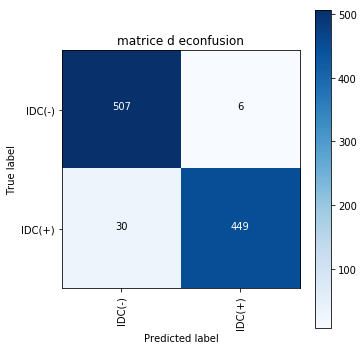

In [22]:
def runKerasCNN(a,b,c,d):
    """
    en a utiliser ce lien
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    en a utilise run model qui marche bien sur MNIST sur notre dataset
    """
    batch_size = 128
    num_classes = 2
    epochs = 5
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    model = Sequential()
    #test d'un premier model
    #test d'un premier model
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu', input_shape = input_shape))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = "softmax"))
    # load weights
    model.load_weights("weights.traint_globalzoom_modelcomplex1.hdf5")
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    model.summary()
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN 1 - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
     
runKerasCNN(X_train, Y_train,  X_test, Y_test)
#plotKerasLearningCurve()